## How well do volunteers do against the aggregate model?

Note this requires the `volunteer_skill_exploration.ipynb` notebook to have been on each `subject_id` and the output notebooks to be saved to `/volunteer_losses`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import json
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gzbuilder_analysis.parsing import unmake_json
from gzbuilder_analysis.fitting import Model, chisq
import lib.galaxy_utilities as gu

In [3]:
models = pd.read_pickle('lib/models.pickle')

In [4]:
models.columns

Index(['aggregate', 'best_individual', 'best_individual_chisq',
       'tuned_aggregate', 'tuned_best_individual', 'tuned_aggregate_chisq',
       'tuned_best_individual_chisq'],
      dtype='object')

In [5]:
tuned_aggregate_chisq = models.tuned_aggregate_chisq
best_individual_chisq = models.best_individual_chisq
tuned_best_individual_chisq = models.tuned_best_individual_chisq

In [6]:
volunteer_losses = pd.Series([], name='best_individual_chisq')
for sid in models.index:
    cluster = pd.read_pickle(f'lib/volunteer_models/{sid}.pickle')
    names = gu.classifications.set_index('classification_id')['user_name'].reindex(cluster.index)
    df = pd.concat((names, cluster['chisq']), axis=1)\
        .sort_values('chisq', ascending=True)\
        .drop_duplicates('user_name')\
        .set_index('user_name')\
        ['chisq']\
        .rename(sid)
    assert df.index.is_unique
    volunteer_losses.loc[sid] = df

In [7]:
loss_df = pd.concat(
    volunteer_losses.values,
    axis=1,
    sort=False,
).T

In [8]:
assert np.allclose(best_individual_chisq, loss_df.min(axis=1))

In [18]:
!ls lib/la*

lib/lackner_nb1.csv lib/lackner_nb4.csv


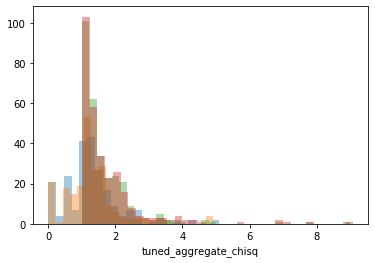

In [25]:
lb1 = pd.read_csv('lib/lackner_nb1.csv')
lb4 = pd.read_csv('lib/lackner_nb4.csv')
sns.distplot(lb1['CHI_SQ_R'], label='Lackner exp+exp', kde=False)
sns.distplot(lb4['CHI_SQ_R'], label='Lackner exp+exp', kde=False)
sns.distplot(tuned_best_individual_chisq,
             label='Tuned Best individual', kde=False)
sns.distplot(tuned_aggregate_chisq,
             label='Tuned Aggregate', kde=False)

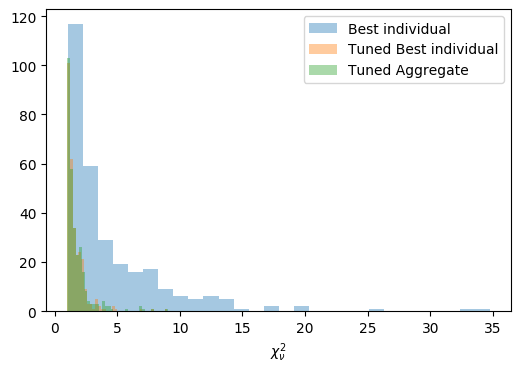

In [10]:
plt.figure(dpi=100)
sns.distplot(best_individual_chisq,
             label='Best individual', kde=False)
sns.distplot(tuned_best_individual_chisq,
             label='Tuned Best individual', kde=False)
sns.distplot(tuned_aggregate_chisq,
             label='Tuned Aggregate', kde=False)
plt.legend()
plt.xlabel(r'$\chi_\nu^2$');

count    2.960000e+02
mean     7.235010e-02
std      6.550450e-01
min     -2.606426e+00
25%     -5.312907e-02
50%      6.397466e-08
75%      6.657015e-02
max      5.422077e+00
dtype: float64

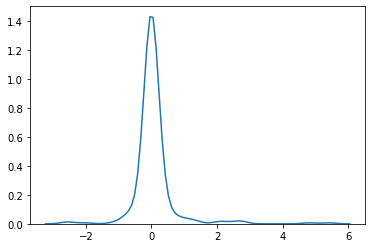

In [11]:
sns.kdeplot(tuned_aggregate_chisq - tuned_best_individual_chisq)
display((tuned_aggregate_chisq - tuned_best_individual_chisq).describe())

In [12]:
p_better_than_agg = pd.Series([])
for name in loss_df.columns:
  res = loss_df[name].dropna()
  if len(res) > 0:
    better = (res - tuned_aggregate_chisq.reindex(res.index) < 0)
    p_better_than_agg.loc[name] = (better < 0).astype(int).sum() / len(res)

$$\mathrm{Ability} = \beta(1 + N_\mathrm{better}, 1 + N_\mathrm{classifications} - N_\mathrm{better})$$

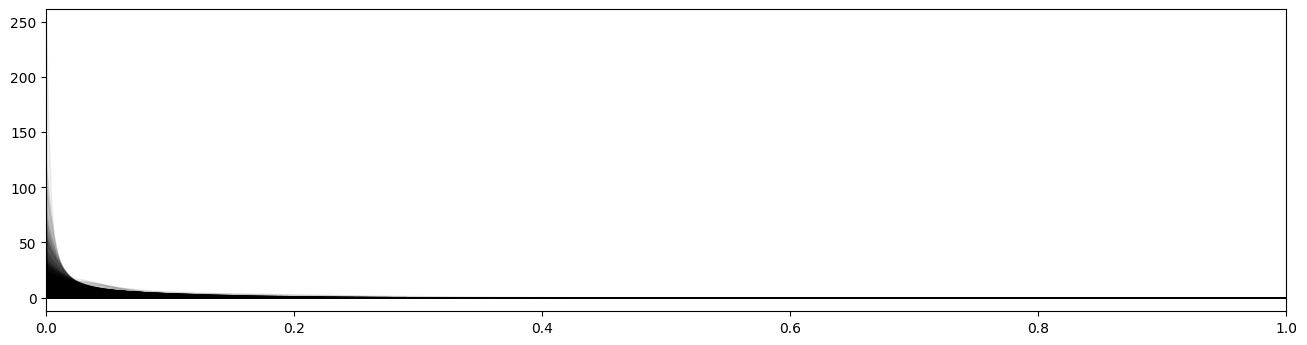

In [13]:
x = np.linspace(0, 1, 500)
five_percentile = pd.Series([])
ninety_five_percentile = pd.Series([])
means = pd.Series([])
medians = pd.Series([])
plt.figure(figsize=(16, 4), dpi=100)
for name in loss_df.columns:
    res = loss_df[name].dropna()
    if len(res) >= 10:
        better = (res - tuned_aggregate_chisq.reindex(res.index) < 0)
        dist = st.beta.pdf(x, 1 + better.sum(), 1 + len(res) - better.sum())
        rvs = st.beta.rvs(1 + better.sum(), 1 + len(res) - better.sum(), size=10000)
        dist_median = st.beta.median(1 + better.sum(), 1 + len(res) - better.sum())
        medians.loc[name] = st.beta.median(1 + better.sum(), 1 + len(res) - better.sum())
        means.loc[name] = st.beta.mean(1 + better.sum(), 1 + len(res) - better.sum())
        five_percentile.loc[name] = np.percentile(rvs, 5)
        ninety_five_percentile.loc[name] = np.percentile(rvs, 95)
        plt.fill_between(x, 0, dist, alpha=0.05, color='k')
plt.xlim(0, 1);

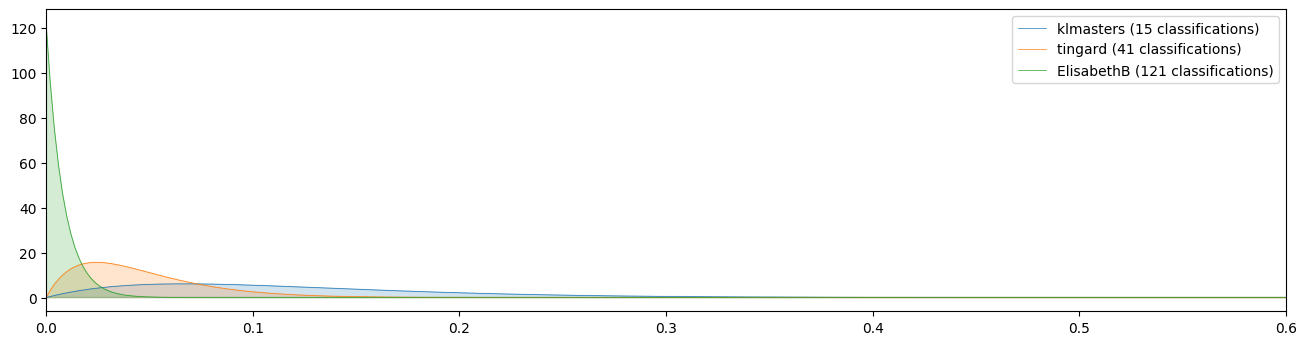

In [14]:
plt.figure(figsize=(16, 4), dpi=100)
for i, name in enumerate(('klmasters', 'tingard', 'ElisabethB')):
    res = loss_df[name].dropna()
    c = 'C{}'.format(i)
    better = (res - tuned_aggregate_chisq.reindex(res.index) < 0)
    dist = st.beta.pdf(x, 1 + better.sum(), 1 + len(res) - better.sum())
    plt.fill_between(x, 0, dist, alpha=0.2, color=c)
    plt.plot(x, dist, c, linewidth=0.5, alpha=1, label='{} ({} classifications)'.format(name, len(res)))
plt.legend()
plt.xlim(0, 0.6);

## Upper 95% confidence bound

What are the upper bounds for volunteers that we are 95% sure they will perform worse than?

In [16]:
ninety_five_percentile.sort_values(ascending=False).head()

not-logged-in-c3e2bb63f9ec3bdeea91    0.368534
bldelacr                              0.365742
klmasters                             0.261046
msalin03                              0.242842
not-logged-in-a0164d241f30411408f0    0.242119
dtype: float64

count    198.000000
mean       0.161151
std        0.066510
min        0.011784
25%        0.111745
50%        0.171908
75%        0.216366
max        0.368534
dtype: float64

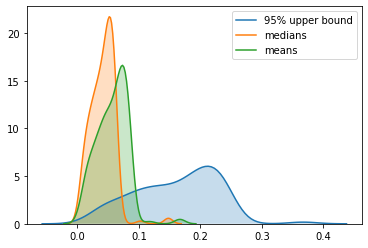

In [17]:
sns.kdeplot(ninety_five_percentile, shade=True, label='95% upper bound')
sns.kdeplot(medians, shade=True, label='medians')
sns.kdeplot(means, shade=True, label='means')
ninety_five_percentile.describe()

So what does this all mean? It means that the tuned best individual model consistently outperforms the tuned aggregate (around 70% of the time). However, for any individual volunteer, we can say with greater than 95% confidence that their raw model will be worse than the tuned aggregate model more than half the time. 

# Identifying Bad fits
- Any component has $R_e=0$ or $I = 0$
- $R_{e, \text{disk}} > 500$
- $R_{e, \text{bulge}} > R_{e, \text{disk}}$ or $R_{e, \text{bar}} > R_{e, \text{disk}}$
- $q_\text{bar} > 0.5$
- Bar position is outside disk effective radius (not accounting for ellipticity)

In [98]:
def is_bad(model):
    disk = model['disk'] if model['disk'] is not None else {}
    bulge = model['bulge'] if model['bulge'] is not None else {}
    bar = model['bar'] if model['bar'] is not None else {}
    bar_offset = np.sqrt(
        (bar.get('mux', disk.get('mux', 0)) - disk.get('mux', 0))**2
        + (bar.get('muy', disk.get('muy', 0)) - disk.get('muy', 0))**2
    ) 
    return {
        'disk_size': disk.get('Re', np.inf) == 0 or disk.get('Re', 0) > 300,
        'bulge_size': bulge.get('Re', np.inf) == 0 or disk.get('Re', np.inf) < bulge.get('Re', -np.inf),
        'bar_size': bar.get('Re', np.inf) == 0 or disk.get('Re', np.inf) < bar.get('Re', 0),
        'zero_brightness_disk': disk.get('I', np.inf) == 0,
        'zero_brightness_bulge': bulge.get('I', np.inf) == 0,
        'zero_brightness_bar': bar.get('I', np.inf) == 0,
        'bar_q': bar.get('q', 0) > 0.5,
        'bar_offset': bar_offset > disk.get('Re', np.inf),
    }

agg_bad = models['aggregate'].apply(is_bad).apply(pd.Series)
tuned_agg_bad = models['tuned_aggregate'].apply(is_bad).apply(pd.Series)

bi_bad = models['best_individual'].apply(is_bad).apply(pd.Series)
tuned_bi_bad = models['tuned_best_individual'].apply(is_bad).apply(pd.Series)

pd.concat((
    (agg_bad.sum() / len(agg_bad)).rename('aggregate'),
    (tuned_agg_bad.sum() / len(tuned_agg_bad)).rename('tuned_aggregate'),
    (bi_bad.sum() / len(bi_bad)).rename('best_individual'),
    (tuned_bi_bad.sum() / len(tuned_bi_bad)).rename('tuned_best_individual')
), axis=1)

,aggregate,tuned_aggregate,best_individual,tuned_best_individual
disk_size,0.000000,0.000000,0.000000,0.003378
bulge_size,0.000000,0.256757,0.003378,0.111486
bar_size,0.010135,0.020270,0.006757,0.020270
zero_brightness_disk,0.000000,0.006757,0.003378,0.003378
zero_brightness_bulge,0.000000,0.155405,0.016892,0.108108
zero_brightness_bar,0.000000,0.020270,0.023649,0.020270
bar_q,0.057432,0.087838,0.067568,0.097973
bar_offset,0.000000,0.000000,0.003378,0.000000
